In [1]:
!pip3 install conllu

### Dataset Extraction

In [2]:
import conllu


# Parse the data using the CoNLL-U format parser
train_data = conllu.parse(
    open("./Dataset/en_atis-ud-train.conllu", "r", encoding="utf-8").read())
valid_data = conllu.parse(
    open("./Dataset/en_atis-ud-dev.conllu", "r", encoding="utf-8").read())
test_data = conllu.parse(
    open("./Dataset/en_atis-ud-test.conllu", "r", encoding="utf-8").read())


train_data = [[(word['form'], word['upostag'])
               for word in sentence] for sentence in train_data]
valid_data = [[(word['form'], word['upostag'])
               for word in sentence] for sentence in valid_data]
test_data = [[(word['form'], word['upostag'])
              for word in sentence] for sentence in test_data]


# Glove Embeddings

In [3]:
import numpy as np
import torch


def load_glove_embeddings(file_path):
    with open(file_path, 'r') as f:
        embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


embeddings = load_glove_embeddings('./glove.6B/glove.6B.100d.txt')
embeddings_list = [embeddings[word] for word in embeddings]
embeddings_matrix = np.array(embeddings_list)
# Add a row of zeros for the padding token
embeddings_matrix = np.vstack((np.zeros(100).astype(np.float32), embeddings_matrix))


/home/abhishek/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PreProcessing 

In [4]:
def dictWCT(data):
    wordCount = {}
    tagCount = {}
    wordFreq = {}
    for sentence in data:
        for word in sentence:
            if word[0] not in wordCount:
                wordCount[word[0]] = len(wordCount)+1
                wordFreq[word[0]] = 1
            else:
                wordFreq[word[0]]+=1
            if word[1] not in tagCount:
                tagCount[word[1]] = len(tagCount)+1
    return wordCount, tagCount, wordFreq


wordToIdx, tagToIdx, wordFreq = dictWCT(train_data+valid_data+test_data)

idxToWord = {v: k for k, v in wordToIdx.items()}
idxToTag = {v: k for k, v in tagToIdx.items()}
wordToIdx['<PAD>'] = 0
wordFreq = {k: v for k, v in wordFreq.items() if v > 2}
wordToIdx['<UNK>'] = len(wordFreq)+1
numUniqueWords = len(wordFreq)+2
numUniqueTags = len(tagToIdx)+1

print("Number of unique words: ", numUniqueWords)
print("Number of unique tags: ", numUniqueTags)

Number of unique words:  555
Number of unique tags:  15


In [5]:
import numpy as np

def getIndices(data, wordToIdx, tagToIdx, wordFreq, min_freq=2):
    wordIndices = []
    tagIndices = []
    mxTagForUnk = {}
    for sentence in data:
        wordIdx = []
        tagIdx = []
        for word in sentence:
            if word[0] not in wordFreq:
                wordIdx.append(wordToIdx['<UNK>'])
                tagIdx.append(tagToIdx[word[1]])
                if word[1] not in mxTagForUnk:
                    mxTagForUnk[word[1]] = 1
                else:
                    mxTagForUnk[word[1]] += 1
            else:
                wordIdx.append(wordToIdx[word[0]])
                tagIdx.append(tagToIdx[word[1]])
        wordIndices.append(wordIdx)
        tagIndices.append(tagIdx)

    mxTagForUnk = max(mxTagForUnk, key=mxTagForUnk.get)
    tagIndices = [[tagToIdx[mxTagForUnk] if word == wordToIdx['<UNK>'] else tag for word, tag in zip(wordIndices[i], tagIndices[i])] for i in range(len(wordIndices))]
    return wordIndices, tagIndices

wordIndices, tagIndices = getIndices(train_data, wordToIdx, tagToIdx, wordFreq)
wordIndicesValid, tagIndicesValid= getIndices(valid_data, wordToIdx, tagToIdx, wordFreq)
wordIndicesTest, tagIndicesTest = getIndices(test_data, wordToIdx, tagToIdx, wordFreq)

def padWCT(wordIndices, tagIndices):
    max_len = 0
    for i in range(len(wordIndices)):
        if len(wordIndices[i]) > max_len:
            max_len = len(wordIndices[i])

    wordIndices = np.array([np.pad(wordIndices[i], (0, max_len - len(wordIndices[i])), 'constant') for i in range(len(wordIndices))])
    tagIndices = np.array([np.pad(tagIndices[i], (0, max_len - len(tagIndices[i])), 'constant') for i in range(len(tagIndices))])

    return wordIndices, tagIndices

wordIndices, tagIndices = padWCT(wordIndices, tagIndices)
wordIndicesValid, tagIndicesValid = padWCT(wordIndicesValid, tagIndicesValid)
wordIndicesTest, tagIndicesTest = padWCT(wordIndicesTest, tagIndicesTest)

# print(charIndices[0].shape)


## Global Variables

In [6]:
# GLOBAL VARIABLES
WORD_EMBEDDING_DIM = 100
LSTM_HIDDEN_DIM_WORD = 256
DROPOUT_RATE = 0.5
BATCH_SIZE = 128
NUM_EPOCHS = 10

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)


cuda:0


## BiLSTM Model

In [12]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTM(nn.Module):
    def __init__(self, numUniqueWords, numUniqueTags, wordEmbeddingDim, lstmHiddenDimWord, dropoutRate,embedding):
        super(BiLSTM, self).__init__()
        self.wordEmbedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding).float(), freeze=False,padding_idx=0)
        self.lstmWord = nn.LSTM(wordEmbeddingDim ,
                                lstmHiddenDimWord, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropoutRate)
        self.linear = nn.Linear(2*lstmHiddenDimWord, numUniqueTags)

    def forward(self,word_indices):
        word_embeddings = self.wordEmbedding(word_indices)
        lstm_word_out = self.lstmWord(word_embeddings)[0]
        lstm_word_out = self.dropout(lstm_word_out)
        linear_out = self.linear(lstm_word_out)
        tag_scores = F.log_softmax(linear_out, dim=2)

        return tag_scores


In [13]:
model = BiLSTM(numUniqueWords, numUniqueTags, WORD_EMBEDDING_DIM, LSTM_HIDDEN_DIM_WORD, DROPOUT_RATE,embeddings_matrix)
if torch.cuda.is_available():
    model.cuda()
    

In [69]:
print(len(wordIndices))

4274


In [14]:
def convertToTensors(wordIndices,tagIndices):
    wordTensor = [torch.LongTensor(word) for word in wordIndices]
    tagTensor = [torch.LongTensor(tag) for tag in tagIndices]
    return wordTensor, tagTensor

wordTensor, tagTensor = convertToTensors(wordIndices, tagIndices)
wordTensorValid, tagTensorValid = convertToTensors(wordIndicesValid, tagIndicesValid)
wordTensorTest, tagTensorTest = convertToTensors(wordIndicesTest, tagIndicesTest)

## Training & Testing

In [15]:
# training model
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss(ignore_index=0)
torch.autograd.set_detect_anomaly(True)

def train(model,optimizer,criterion, wordTensor,tagTensor):
    model.train()
    total_loss = 0
    tot_correct = 0
    total_pad = 0
    for i in range(0,len(wordIndices),BATCH_SIZE):
        optimizer.zero_grad()
        word_tensor = wordTensor[i:i+BATCH_SIZE]
        tag_tensor = tagTensor[i:i+BATCH_SIZE]
        word_tensor = torch.stack(word_tensor).to(device)
        tag_tensor = torch.stack(tag_tensor).to(device)
        tag_tensor = tag_tensor.view(-1)
        output = model(word_tensor)
        output = output.view(-1, output.shape[2])
        loss = criterion(output, tag_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        tot_correct += torch.sum(pred == tag_tensor).item()

        total_pad += torch.sum(tag_tensor == 0).item()
        
    return total_loss, tot_correct/(len(wordIndices)*len(wordIndices[0]) - total_pad)


def evaluate(model, wordTensor, tagTensor):
    model.eval()
    total_loss = 0
    tot_correct = 0
    total_pad = 0
    wordTagList = []
    with torch.no_grad():
        for i in range(0, len(wordTensor), BATCH_SIZE):
            word_tensor = wordTensor[i:i+BATCH_SIZE]
            tag_tensor = tagTensor[i:i+BATCH_SIZE]
            word_tensor = torch.stack(word_tensor).to(device)
            tag_tensor = torch.stack(tag_tensor).to(device)
            tag_tensor = tag_tensor.view(-1)
            output = model(word_tensor)
            output = output.view(-1, output.shape[2])
            loss = criterion(output, tag_tensor)
            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            tot_correct += torch.sum(pred == tag_tensor).item()
            total_pad += torch.sum(tag_tensor == 0).item()
            # take those only which are not padded
            wordTagList.extend(
                list(zip(word_tensor.view(-1).tolist(), pred.view(-1).tolist())))
    return total_loss, tot_correct/(len(wordTensor)*len(wordTensor[0]) - total_pad), wordTagList

loss_list  = []
accuracy_list = []
validaton_loss_list = []
validaton_accuracy_list = []
for epoch in range(NUM_EPOCHS):
    loss,totalCorrect = train(model,optimizer,criterion,wordTensor,tagTensor)
    lossValid,totalCorrectValid,_ = evaluate(model,wordTensorValid,tagTensorValid)
    print("Epoch: {0} \t Training Loss: {1} \t Training Accuracy: {2} \t Validation Loss: {3} \t Validation Accuracy: {4}".format(epoch+1,loss,totalCorrect,lossValid,totalCorrectValid))
    loss_list.append(loss)
    accuracy_list.append(totalCorrect)
    validaton_loss_list.append(lossValid)
    validaton_accuracy_list.append(totalCorrectValid)



Epoch: 1 	 Training Loss: 29.273948587477207 	 Training Accuracy: 0.7180145925393073 	 Validation Loss: 1.1001158729195595 	 Validation Accuracy: 0.9294099939795304
Epoch: 2 	 Training Loss: 5.096950709819794 	 Training Accuracy: 0.9611139656767034 	 Validation Loss: 0.40961023047566414 	 Validation Accuracy: 0.9706502107164359
Epoch: 3 	 Training Loss: 2.609059365466237 	 Training Accuracy: 0.9783783783783784 	 Validation Loss: 0.336295448243618 	 Validation Accuracy: 0.9750150511739916
Epoch: 4 	 Training Loss: 2.2211140040308237 	 Training Accuracy: 0.9831466447436029 	 Validation Loss: 0.23998620733618736 	 Validation Accuracy: 0.9829921733895244
Epoch: 5 	 Training Loss: 1.9095498565584421 	 Training Accuracy: 0.9831466447436029 	 Validation Loss: 0.23535828478634357 	 Validation Accuracy: 0.9867549668874173
Epoch: 6 	 Training Loss: 1.8607068192213774 	 Training Accuracy: 0.9842976055903813 	 Validation Loss: 0.23752260208129883 	 Validation Accuracy: 0.9867549668874173
Epoch: 7 

In [16]:
# save the model
torch.save(model.state_dict(), "modelFinal.pt")


In [17]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# for precision , recall , f1 score
def getMetrices(y_pred,y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    print(classification_report(y_true, y_pred, digits=4))  


model.load_state_dict(torch.load("modelFinal.pt"))
lossTest, totalCorrectTest, wlList = evaluate(
    model, wordTensorTest, tagTensorTest)

test_pred = [v for k,v in wlList if k != 0]
word_list = [k for k,v in wlList if k != 0]
test_actual = []
for i in range(len(tagIndicesTest)):
    test_actual.extend(tagIndicesTest[i])
# remove the padded values
test_actual = [v for v in test_actual if v != 0]

getMetrices(test_pred,test_actual)



              precision    recall  f1-score   support

           1     0.9924    0.9974    0.9949       392
           2     0.9961    0.9922    0.9941       256
           3     0.9903    0.9941    0.9922       512
           4     0.9965    0.9948    0.9957      1155
           5     0.9965    0.9930    0.9948      1433
           6     0.9936    0.9994    0.9965      1549
           7     0.9951    0.9903    0.9927       618
           8     0.9943    1.0000    0.9971       173
           9     0.9764    0.9495    0.9628       218
          10     1.0000    1.0000    1.0000       109
          11     0.8800    0.9041    0.8919        73
          12     0.9649    0.9821    0.9735        56
          13     1.0000    1.0000    1.0000        36

    accuracy                         0.9927      6580
   macro avg     0.9828    0.9844    0.9835      6580
weighted avg     0.9927    0.9927    0.9927      6580



In [18]:

with open("test.txt", "w") as f:
    # write the header
    f.write("{0} {1} {2}\n".format("Word", "Actual", "Predicted"))
    for i in range(len(word_list)):
        f.write("{0} {1} {2}\n".format( idxToWord[word_list[i]], idxToTag[test_actual[i]], idxToTag[test_pred[i]]))
            
            

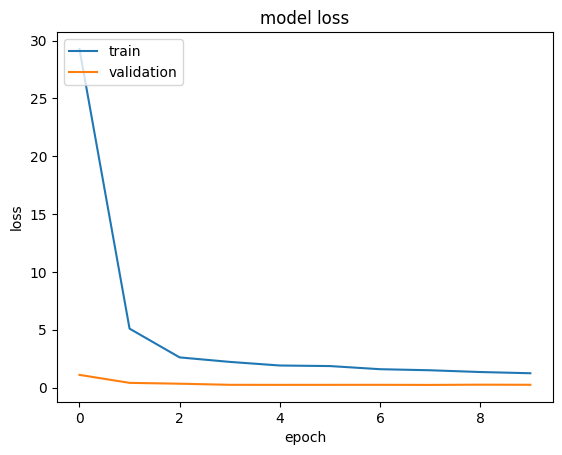

In [19]:
# matplotlb for plotting loss for training and validation
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.plot(validaton_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


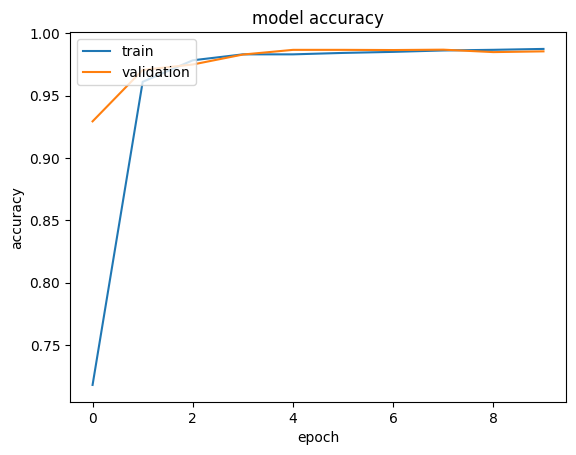

In [20]:
# matplotlb for plotting accuracy for training and validation
plt.plot(accuracy_list)
plt.plot(validaton_accuracy_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## Random Sentence Tagging

In [22]:

s = "we are coming from india"
model.load_state_dict(torch.load("modelFinal.pt"))

def genSentence(model,wordFreq,sentence):
    sentence = sentence.lower()
    sentence = sentence.split(" ")
    word_indice = []
    for s in sentence:
        if s not in wordFreq or wordFreq[s]<=2:
            word_indice.append(wordToIdx['<UNK>'])
        else:
            word_indice.append(wordToIdx[s])
    wordTen = torch.LongTensor(word_indice).to(device)
    wordTen = wordTen.view(1,-1)
    # predict the tag
    with torch.no_grad():
        model.eval()
        output = model(wordTen)
        _, predicted = torch.max(output, 2)
        # print(predicted.shape)
        for i in range(len(predicted[0])):
            print(sentence[i], idxToTag[predicted[0][i].item()])


genSentence(model,wordFreq,s)



we PRON
are AUX
coming VERB
from ADP
india NUM
